# Risk Models Using Tree-based Models

Welcome to the second assignment of Course 2!


In this assignment, you'll gain experience with tree based models by predicting the 10-year risk of death of individuals from the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)). This is a challenging task and a great test bed for the machine learning methods we learned this week.

As you go through the assignment, you'll learn about: 

- Dealing with Missing Data
  - Complete Case Analysis.
  - Imputation
- Decision Trees
  - Evaluation.
  - Regularization.
- Random Forests 
  - Hyperparameter Tuning.

## Table of Contents

- [1. Import Packages](#1)
- [2. The Dataset](#2)
    - [2.1 Explore the Dataset](#2-1)
    - [2.2 Dealing with Missing Data](#2-2)
        - [Exercise 1 - fraction_rows_missing](#ex-1)
- [3. Decision Trees](#3)
    - [Exercise 2 - dt_hyperparams](#ex-2)
- [4. Random Forests](#4)
    - [Exercise 3 - random_forest_grid_search](#ex-3)
- [5. Imputation](#5)
    - [5.1 Error Analysis](#5-1)
        - [Exercise 4 - bad_subset](#ex-4)
    - [5.2 Imputation Approaches](#5-2)
        - [Exercise 5 - hyperparams](#ex-5)
        - [Exercise 6 - hyperparams](#ex-6)
- [6. Comparison](#6)
- [7. Explanations: SHAP](#7)

<a name='1'></a>
## 1. Import Packages

We'll first import all the common packages that we need for this assignment. 

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [1]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

# We'll also import some helper functions that will be useful later on.
from util import load_data, cindex
from public_tests import *

<a name='2'></a>
## 2. The Dataset

Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [2]:
X_dev, X_test, y_dev, y_test = load_data(10, 'data/NHANESI_subset_X.csv', 'data/NHANESI_subset_y.csv')

The dataset has been split into a development set (or dev set), which we will use to develop our risk models, and a test set, which we will use to test our models.

We further split the dev set into a training and validation set, respectively to train and tune our models, using a 75/25 split (note that we set a random state to make this split repeatable).

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

<a name='2-1'></a>
### 2.1 Explore the Dataset

The first step is to familiarize yourself with the data. Run the next cell to get the size of your training set and look at a small sample. 

In [4]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


Our targets `y` will be whether or not the target died within 10 years. Run the next cell to see the target data series.

In [5]:
y_train.head(20)

1599    False
2794     True
1182    False
6915    False
500     False
1188     True
9739    False
3266    False
6681    False
8822    False
5856     True
3415    False
9366    False
7975    False
1397    False
6809    False
9461    False
9374    False
1170     True
158     False
Name: time, dtype: bool

Use the next cell to examine individual cases and familiarize yourself with the features.

In [6]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


<a name='2-2'></a>
### 2.2 Dealing with Missing Data

Looking at our data in `X_train`, we see that some of the data is missing: some values in the output of the previous cell are marked as `NaN` ("not a number").

Missing data is a common occurrence in data analysis, that can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern. `seaborn` is an alternative to `matplotlib` that has some convenient plotting functions for data analysis. We can use its `heatmap` function to easily visualize the missing data pattern.

Run the cell below to plot the missing data: 

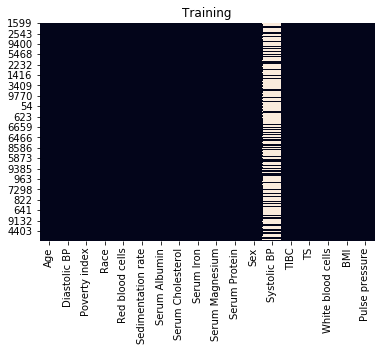

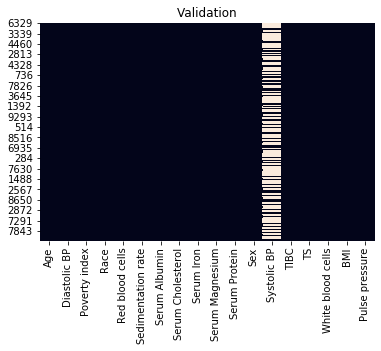

In [7]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).


<a name='ex-1'></a>
### Exercise 1 - fraction_rows_missing

In the cell below, write a function to compute the fraction of cases with missing data. This will help us decide how we handle this missing data in the future.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> The <code>pandas.DataFrame.isnull()</code> method is helpful in this case.</li>
    <li> Use the <code>pandas.DataFrame.any()</code> method and set the <code>axis</code> parameter.</li>
    <li> Divide the total number of rows with missing data by the total number of rows. Remember that in Python, <code>True</code> values are equal to 1.</li>
</ul>
</p>

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    
    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''
    ### START CODE HERE (REPLACE 'None' with your code) ###
    return sum(df.isnull().any(axis=1))/df.shape[0]
    ### END CODE HERE ###

In [9]:
### test cell ex1 - do not modify this test cell   
fraction_rows_missing_test(fraction_rows_missing, X_train, X_val, X_test)

Example dataframe:

      a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0 

Computed fraction missing:  0.75
Fraction of rows missing from X_train:  0.6986594132504371
Fraction of rows missing from X_val:  0.703962703962704
Fraction of rows missing from X_test:  0.0
 All tests passed.


#### Expected Output:
```
Computed fraction missing:  0.75
Fraction of rows missing from X_train:  0.6986594132504371
Fraction of rows missing from X_val:  0.703962703962704
Fraction of rows missing from X_test:  0.0
 All tests passed.
``` 

We see that our train and validation sets have missing values, but luckily our test set has complete cases.

As a first pass, we will begin with a **complete case analysis**, dropping all of the rows with any missing data. Run the following cell to drop these rows from our train and validation sets. 

In [10]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

### Notice the new shape of X
print("X_train_dropped shape: {}".format(X_train_dropped.shape))
X_train_dropped.head() 

X_train_dropped shape: (1551, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
5856,67.0,94.0,114.0,1.0,43.8,12.0,3.7,178.0,73.0,1.85,7.0,1.0,140.0,311.0,23.5,4.3,17.481227,46.0
9374,68.0,80.0,201.0,1.0,46.2,20.0,4.1,223.0,204.0,1.54,7.2,1.0,140.0,275.0,74.2,17.2,20.690581,60.0
8819,68.0,80.0,651.0,1.0,47.7,16.0,4.3,178.0,168.0,1.97,7.3,1.0,102.0,339.0,49.6,10.2,27.719091,22.0
7331,73.0,88.0,68.0,2.0,42.1,19.0,3.6,215.0,64.0,1.59,5.7,2.0,190.0,334.0,19.2,6.6,31.880432,102.0


<a name='3'></a>
## 3. Decision Trees

Having just learned about decision trees, you choose to use a decision tree classifier. Use scikit-learn to build a decision tree for the hospital dataset using the train set.

In [11]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

Next we will evaluate our model. We'll use C-Index for evaluation.

> Remember from lesson 4 of week 1 that the C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

Run the next cell to compute the C-Index on the train and validation set (we've given you an implementation this time).

In [12]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")


y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


Unfortunately your tree seems to be overfitting: it fits the training data so closely that it doesn't generalize well to other samples such as those from the validation set.

> The training C-index comes out to 1.0 because, when initializing `DecisionTreeClasifier`, we have left `max_depth` and `min_samples_split` unspecified. The resulting decision tree will therefore keep splitting as far as it can, which pretty much guarantees a pure fit to the training data.

To handle this, you can change some of the hyperparameters of our tree.

<a name='ex-2'></a>
### Exercise 2 - dt_hyperparams

Try and find a set of hyperparameters that improves the generalization to the validation set and recompute the C-index. If you do it right, you should get C-index above 0.6 for the validation set. 

You can refer to the documentation for the sklearn [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Try limiting the depth of the tree (max_depth).</li>
</ul>
</p>

In [13]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###
    'max_depth' : 3
    
    ### END CODE HERE ###
}


Run the next cell to fit and evaluate the regularized tree.

In [14]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.688738755448391
Val C-Index (expected > 0.6): 0.6302692819148936


#### Expected Output:
```
Train C-Index > 0.6
Val C-Index > 0.6
```

If your output is not greater than `0.6`, try changing and tweaking your hyperparameters in `Ex 2`.

If you used a low `max_depth` you can print the entire tree. This allows for easy interpretability. Run the next cell to print the tree splits. 

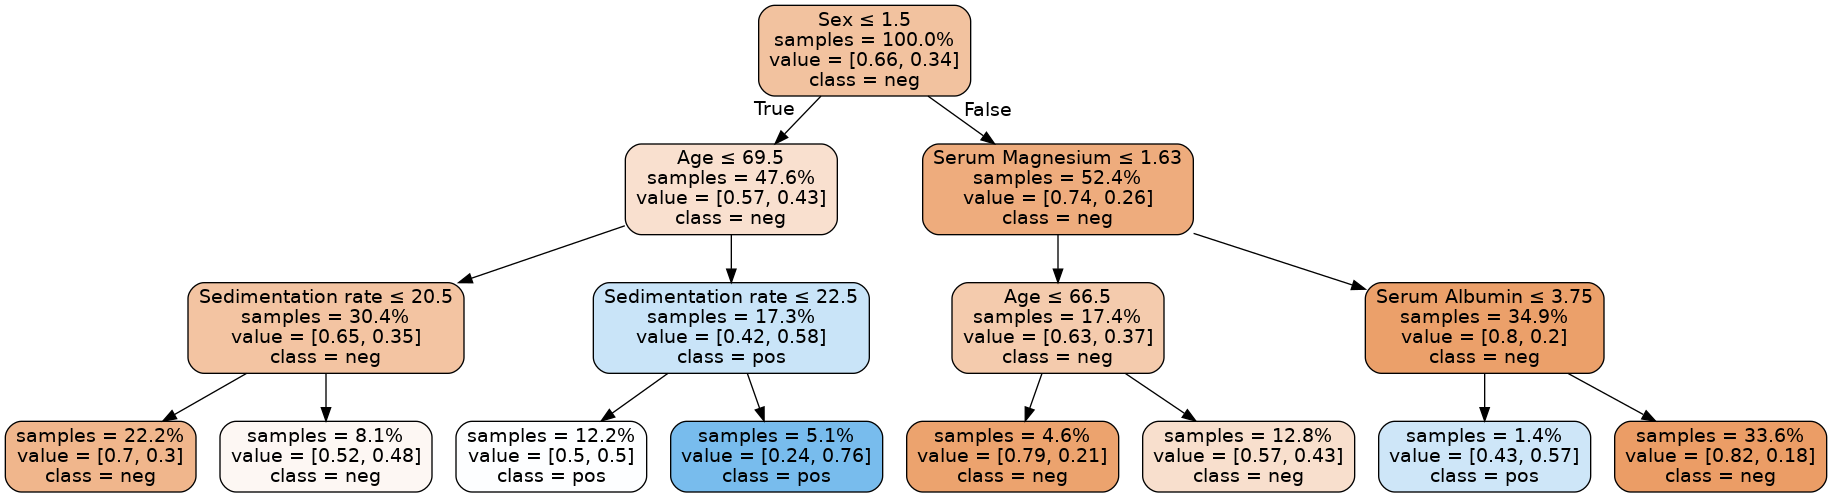

In [15]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,  
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

> **Overfitting, underfitting, and the bias-variance tradeoff**
>
> If you tested several values of `max_depth`, you may have seen that a value of `3` gives training and validation C-Indices of about `0.689` and `0.630`, and that a `max_depth` of `2` gives better agreement with values of about `0.653` and `0.607`. In the latter case, we have further reduced overfitting, at the cost of a minor loss in predictive performance.
>
> Contrast this with a `max_depth` value of `1`, which results in C-Indices of about `0.597` for the training set and `0.598` for the validation set: we have eliminated overfitting but with a much stronger degradation of predictive performance.
>
> Lower predictive performance on the training and validation sets is indicative of the model _underfitting_ the data: it neither learns enough from the training data nor is able to generalize to unseen data (the validation data in our case).
>
> Finding a model that minimizes and acceptably balances underfitting and overfitting (e.g. selecting the model with a `max_depth` of `2` over the other values) is a common problem in machine learning that is known as the _bias-variance tradeoff_.

<a name='4'></a>
## 4. Random Forests

No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier. 

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

Now compute and report the C-Index for the random forest on the training and validation set.

In [17]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [18]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)
        
        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)
        
        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params 
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

<a name='ex-3'></a>
### Exercise 3 - random_forest_grid_search

In the cell below, define the values you want to run the hyperparameter grid search on, and run the cell to find the best-performing set of hyperparameters.

Your objective is to get a C-Index above `0.6` on both the train and validation set.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>

In [19]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        
        ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [5],

        # the maximum depth of trees in the forest (int)
        
        'max_depth': [3],
        
        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [1],

        ### END CODE HERE ###
    }

    
    fixed_hyperparams = {
        'random_state': 10,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [20]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/1] {'n_estimators': 5, 'max_depth': 3, 'min_samples_leaf': 1}
Val C-Index: 0.6542386968085107

Best hyperparameters:
{'n_estimators': 5, 'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 10}
Train C-Index: 0.7171334508021886
Val C-Index: 0.6542386968085107


Finally, evaluate the model on the test set. This is a crucial step, as trying out many combinations of hyperparameters and evaluating them on the validation set could result in a model that ends up overfitting the validation set. We therefore need to check if the model performs well on unseen data, which is the role of the test set, which we have held out until now.

In [21]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.6346050799544323


#### Expected Output:
```
Test C-Index > 0.6
```

If your output is not greater than `0.6`, try changing and tweaking your hyperparameters in `Ex 3`.

<a name='5'></a>
## 5. Imputation

You've now built and optimized a random forest model on our data. However, there was still a drop in test C-Index. This might be because you threw away more than half of the data of our data because of missing values for systolic blood pressure. Instead, we can try filling in, or imputing, these values. 

First, let's explore to see if our data is missing at random or not. Let's plot histograms of the dropped rows against each of the covariates (aside from systolic blood pressure) to see if there is a trend. Compare these to the histograms of the feature in the entire dataset. Try to see if one of the covariates has a signficantly different distribution in the two subsets.

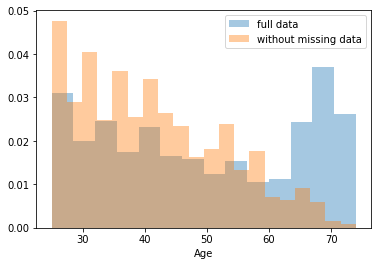

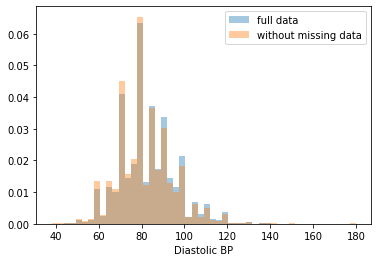

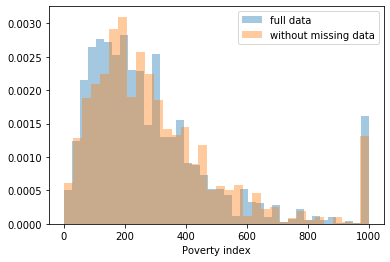

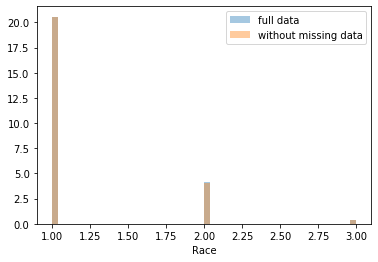

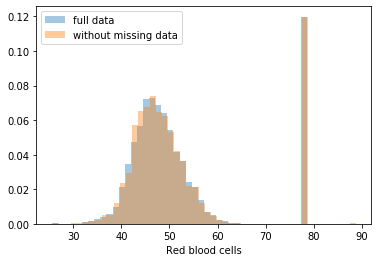

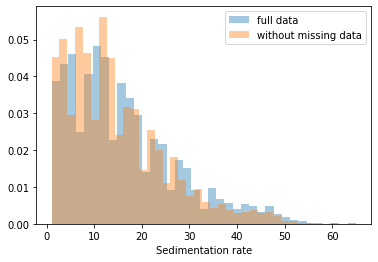

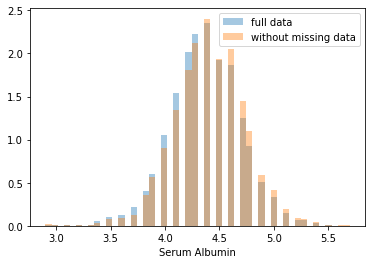

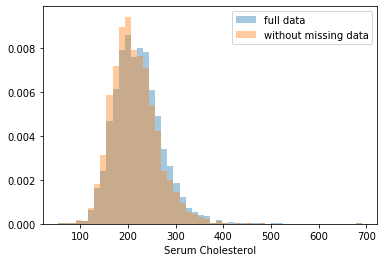

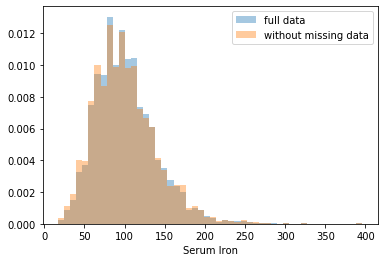

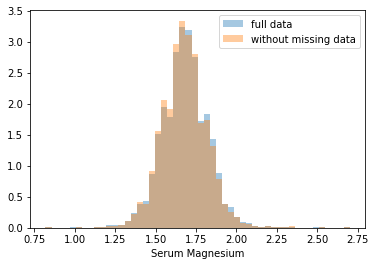

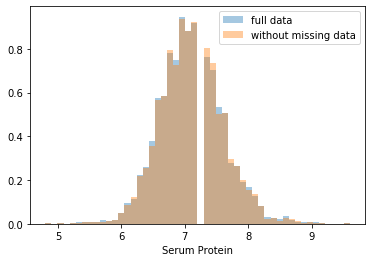

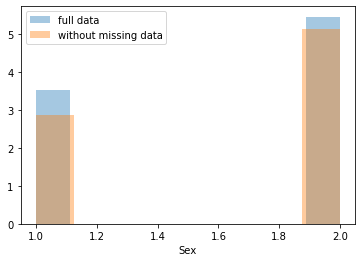

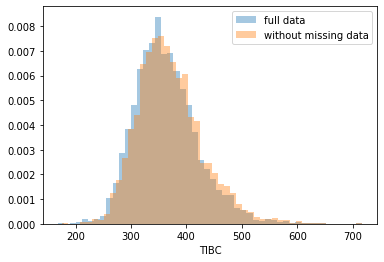

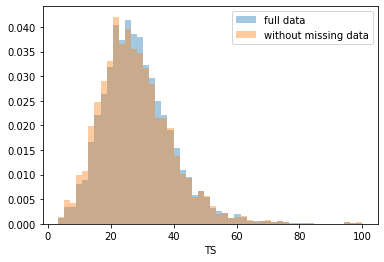

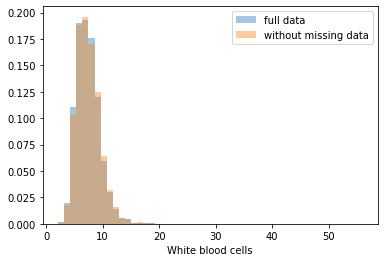

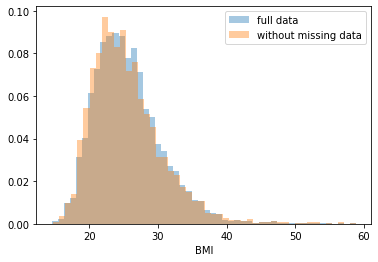

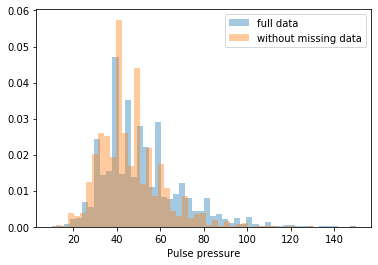

In [22]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()

    plt.show()

Most of the covariates are distributed similarly whether or not we have discarded rows with missing data. In other words missingness of the data is independent of these covariates.

If this had been true across *all* covariates, then the data would have been said to be **missing completely at random (MCAR)**.

But when considering the age covariate, we see that much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them.

As missingness is related to one or more covariates, the missing data is said to be **missing at random (MAR)**.

Based on the information we have, there is however no reason to believe that the _values_ of the missing data — or specifically the values of the missing systolic blood pressures — are related to the age of the patients. 
If this was the case, then this data would be said to be **missing not at random (MNAR)**.

<a name='5-1'></a>
### 5.1 Error Analysis

<a name='ex-4'></a>
### Exercise 4 - bad_subset
Using the information from the plots above, try to find a subgroup of the test data on which the model performs poorly. You should be able to easily find a subgroup of at least 250 cases on which the model has a C-Index of less than 0.69.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Define a mask using a feature and a threshold, e.g. patients with a BMI below 20: <code>mask = X_test['BMI'] < 20 </code>. </li>
    <li> Try to find a subgroup for which the model had little data.</li>
</ul>
</p>

In [53]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    # currently mask defines the entire set
    
    ### START CODE HERE (REPLACE the code after 'mask =' with your code) ###
    mask = X_test['BMI']<23
    
    ### END CODE HERE ###

    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [54]:
#### Test Your Work
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69")
print(f"Your Subgroup size: {subgroup_size}, and your C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69
Your Subgroup size: 602, and your C-Index: 0.6662593139501333


#### Expected Output
Note, your actual output will vary depending on the hyperparameters and the mask that you chose.

```Python
Your Subgroup size > 250, and your C-Index < 0.69
```

<a name='5-2'></a>
### 5.2 Imputation Approaches

Seeing that our data is not missing completely at random, we can handle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation.

The first imputation strategy that we will use is **mean substitution**: we will replace the missing values for each feature with the mean of the available values. In the next cell, use the `SimpleImputer` from `sklearn` to use mean imputation for the missing values.

In [25]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

<a name='ex-5'></a>
### Exercise 5 - hyperparams
Now perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set. 

Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>


In [26]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

    # how many trees should be in the forest (int)
    'n_estimators': [130],

    # the maximum depth of trees in the forest (int)
    'max_depth': [5],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [1],

    ### END CODE HERE ###
}

In [27]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/1] {'n_estimators': 130, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.7474274708548028

Performance for best hyperparameters:
- Train C-Index: 0.8118
- Val C-Index: 0.7474
- Test C-Index: 0.7824


#### Expected output
Note, your actual C-Index values will vary depending on the hyperparameters that you choose.

```
C-Index >= 0.74
```

- Try to get a good C-Index, similar these numbers below:

```Python
Performance for best hyperparameters:
- Train C-Index: 0.8109
- Val C-Index: 0.7495
- Test C-Index: 0.7805
```

Next, we will apply another imputation strategy, known as **multivariate feature imputation**, using scikit-learn's `IterativeImputer` class (see the [documentation](https://scikit-learn.org/stable/modules/impute.html#iterative-imputer)).

With this strategy, for each feature that is missing values, a regression model is trained to predict observed values based on all of the other features, and the missing values are inferred using this model.
As a single iteration across all features may not be enough to impute all missing values, several iterations may be performed, hence the name of the class `IterativeImputer`.

In the next cell, use `IterativeImputer` to perform multivariate feature imputation.

> Note that the first time the cell is run, `imputer.fit(X_train)` may fail with the message `LinAlgError: SVD did not converge`: simply re-run the cell.

In [28]:
# Impute using regression on other covariates
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

<a name='ex-6'></a>
### Exercise 6 - hyperparams

Perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set. Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

#### Target performance

Try to get a text c-index of at least 0.74 or higher.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>n_estimators: try values greater than 100</li>
    <li>max_depth: try values in the range 1 to 100</li>
    <li>min_samples_leaf: try float values below .5 and/or int values greater than 2</li>
</ul>
</p>


In [38]:
# Define ranges for the random forest hyperparameter search 
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

    # how many trees should be in the forest (int)
    'n_estimators': [120],

    # the maximum depth of trees in the forest (int)
    'max_depth': [5],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [3],

    ### END CODE HERE ###
}

In [39]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/1] {'n_estimators': 120, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.7433789537911013

Performance for best hyperparameters:
- Train C-Index: 0.8132
- Val C-Index: 0.7434
- Test C-Index: 0.7799


#### Expected Output
Note, your actual C-Index values will vary depending on the hyperparameters that you choose.

```
C-Index >= 0.74
```

- Try to get a good C-Index, similar these numbers below:

```Python
Performance for best hyperparameters:
- Train C-Index: 0.8131
- Val C-Index: 0.7454
- Test C-Index: 0.7797
```

<a name='6'></a>
## 6. Comparison

For good measure, retest on the subgroup from before to see if your new models do better.

In [40]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6316729674253354
C-Index (mean imputation): 0.781078280390021
C-Index (multivariate feature imputation): 0.7784368226500306


We should see that avoiding complete case analysis (i.e. analysis only on observations for which there is no missing data) allows our model to generalize a bit better. Remember to examine your missing cases to judge whether they are missing at random or not!

<a name='7'></a>
## 7. Explanations: SHAP

Using a random forest has improved results, but we've lost some of the natural interpretability of trees. In this section we'll try to explain the predictions using slightly more sophisticated techniques. 

You choose to apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method that explains predictions made by black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).

> Given a prediction made by a machine learning model, SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, where Shapley values are used to quantify the contribution of each player to the game.
> 
> Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

We'll use the [shap library](https://github.com/slundberg/shap) to do this for our random forest model. Run the next cell to output the most at risk individuals in the test set according to our model.

In [32]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.626468
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.560718
6337,69.0,80.0,233.0,1.0,77.7,48.0,4.2,159.0,87.0,1.81,6.9,1.0,146.0,291.0,29.9,15.2,17.931276,66.0,0.529334
2050,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.522071
6609,72.0,90.0,75.0,1.0,29.3,59.0,3.9,216.0,64.0,1.63,7.4,2.0,182.0,322.0,19.9,9.3,22.281793,92.0,0.521704


We can use SHAP values to try and understand the model output on specific individuals using force plots. Run the cell below to see a force plot on the riskiest individual. 

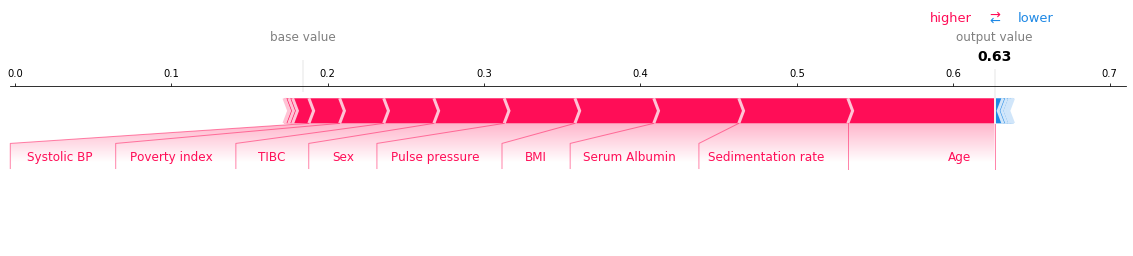

In [33]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In [34]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

Run the next cell to see a summary plot of the SHAP values for each feature on each of the test examples. The colors indicate the value of the feature.

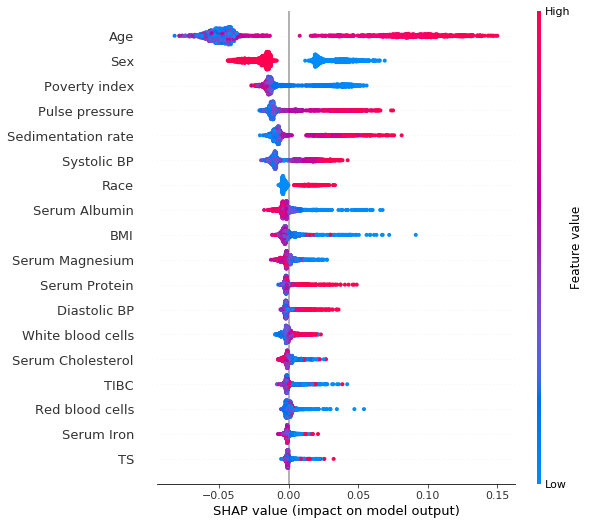

In [35]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality. 

You can see how features interact using dependence plots. These plot the SHAP value for a given feature for each data point, and color the points in using the value for another feature. This lets us begin to explain the variation in SHAP value for a single value of the main feature.

Run the next cell to see the interaction between Age and Sex.

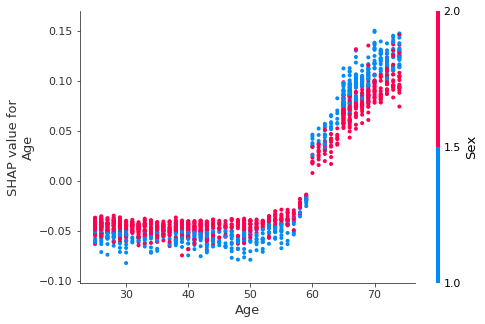

In [36]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')

We see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

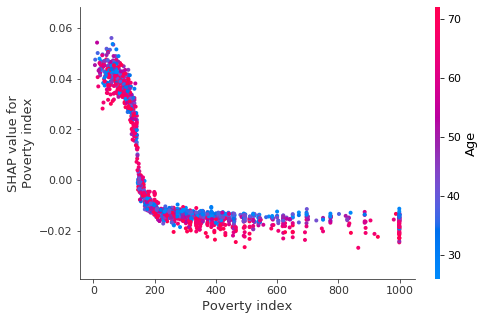

In [37]:
shap.dependence_plot('Poverty index', shap_values, X_test, interaction_index='Age')

We see that the impact of poverty index drops off quickly, and for higher income individuals age begins to explain much of variation in the impact of poverty index.

Try some other pairs and see what other interesting relationships you can find!

# Congratulations!

You have completed the second assignment in Course 2. Along the way you've learned to fit decision trees, random forests, and deal with missing data. Now you're ready to move on to week 3!